# Example: projection

[Example Data](https://pan.baidu.com/s/1nwsIcDr?pwd=s5re) <span style="color:gray"></span>

[User Module Download](https://github.com/lydiazly/lydiazly.github.io/raw/main/source/downloads/scripts/sunpy-modules.zip) ([help](https://lydiazly.github.io/usr_sunpy.html))

In [1]:
from __future__ import division, print_function

# Reload user modules automatically
# %load_ext autoreload
# %autoreload 2

# notebook, inline, ...
%matplotlib notebook

from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
from copy import deepcopy

# To use user modules
import sys
sys.path.append('../modules')

# print('Python version: %s' % sys.version.split('(')[0])  # Python version: 3.6.6 |Anaconda, Inc.|
# print('SunPy version: %s' % sunpy.__version__)  # SunPy version: 0.9.3

## Read data

In [2]:
fnames = ('data/hmi.B_720s.20150827_052400_TAI.field.fits',
          'data/hmi.B_720s.20150827_052400_TAI.inclination.fits',
          'data/hmi.B_720s.20150827_052400_TAI.azimuth.fits',
          'data/hmi.B_720s.20150827_052400_TAI.disambig.fits')

In [3]:
from usr_sunpy import read_sdo
mapb, mapi, mapa, mapd = list(map(read_sdo, fnames))

hmi.B_720s.20150827_052400_TAI.field.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.inclination.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.azimuth.fits	[4096, 4096]
hmi.B_720s.20150827_052400_TAI.disambig.fits	[4096, 4096]


In [4]:
# Disambiguate
mapa.data[mapd.data > 3] += 180.

mapbx = deepcopy(mapb)
mapby = deepcopy(mapb)
mapbz = deepcopy(mapb)
mapbx.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.cos(np.deg2rad(mapa.data + 270.))
mapby.data[:] = mapb.data * np.sin(np.deg2rad(mapi.data)) * np.sin(np.deg2rad(mapa.data + 270.))
mapbz.data[:] = mapb.data * np.cos(np.deg2rad(mapi.data))

# Suppress metadata warnings
for i in {mapbx, mapby, mapbz}:
    i.meta['hgln_obs'] = 0.

from usr_sunpy import aiaprep_usr as aiaprep
import warnings
print('level 1 -> level 1.5 ...')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mapbx = aiaprep(mapbx)
    mapby = aiaprep(mapby)
    mapbz = aiaprep(mapbz)
print('level    =', mapbz.meta['lvl_num'])
print('rsun_obs =', mapbz.meta['rsun_obs'] * u.arcsec)
print('r_sun    =', mapbz.meta['r_sun'] * u.pix)

level 1 -> level 1.5 ...
level    = 1.5
rsun_obs = 949.495178 arcsec
r_sun    = 1582.4919633333334 pix


## Submap

Submap: ([500. 800.], [-450. -200.]) arcsec  (500 x 417)


<IPython.core.display.Javascript object>


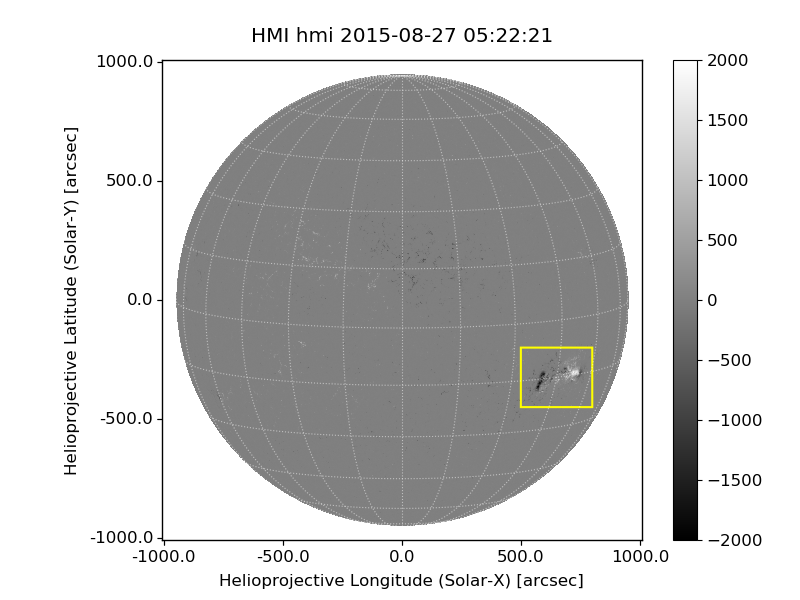

In [5]:
xrange = (500.,800.) * u.arcsec
yrange = (-450.,-200.) * u.arcsec

subcoord = SkyCoord(xrange, yrange, frame=mapbz.coordinate_frame)
smapbx = mapbx.submap(subcoord)
smapby = mapby.submap(subcoord)
smapbz = mapbz.submap(subcoord)
print('Submap: (%s, %s) arcsec  (%d x %d)'
      % (xrange.value, yrange.value, *smapbz.data.shape[::-1]))

from usr_sunpy import plot_map
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax1 = fig1.add_subplot(111, projection=mapbz)
plot_map(mapbz, ax=ax1, vmin=-2000., vmax=2000., grid_color='w')
mapbz.draw_rectangle(subcoord[0], xrange[1]-xrange[0], yrange[1]-yrange[0], axes=ax1, color='yellow', linewidth=1.5)

# Specify xlim, ylim by pixels
# lim_arcsec = ((-1000.1, 1000.1) * u.arcsec, (-1000.1, 1000.1) * u.arcsec)
# lim_pix = mapbz.world_to_pixel(SkyCoord(*lim_arcsec, frame=mapbz.coordinate_frame))  # pix
# ax1.set_xlim(lim_pix[0].value)  # pix
# ax1.set_ylim(lim_pix[1].value);  # pix

# Clip NaNs
valid_index = np.where(np.isfinite(mapbz.data))
ax1.set_xlim((valid_index[0].min()-100, valid_index[0].max()+100))  # pix
ax1.set_ylim((valid_index[1].min()-100, valid_index[1].max()+100));  # pix

<IPython.core.display.Javascript object>


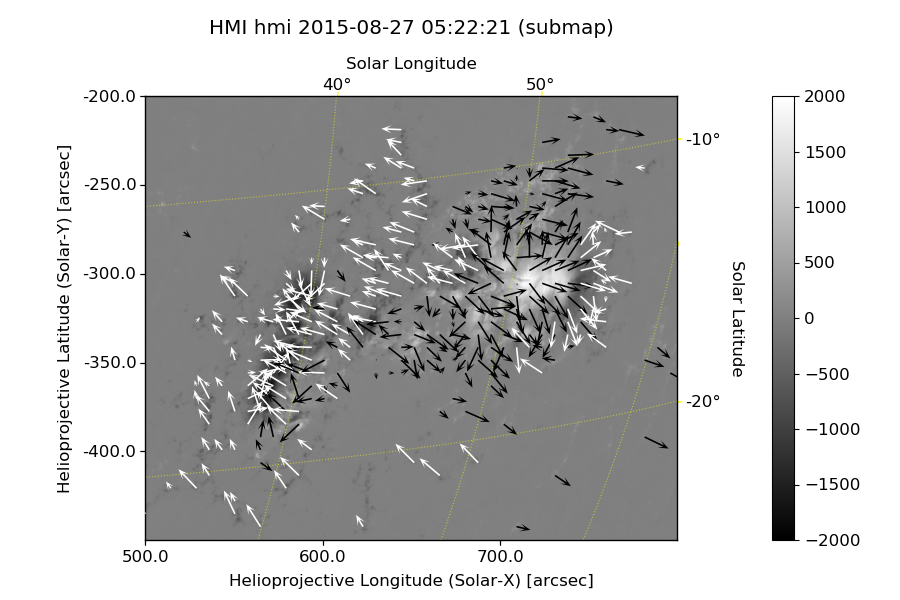

In [6]:
from usr_sunpy import plot_map, plot_vmap

iskip, jskip = (12, 12)

fig2 = plt.figure(figsize=(9, 6), dpi=100)
ax2 = fig2.add_subplot(111, projection=smapbz)
im2 = plot_map(smapbz, ax=ax2, vmin=-2000., vmax=2000., grid=10*u.deg, title=mapbz.latex_name+' (submap)')
plot_vmap(smapbx, smapby, smapbz, ax2, iskip=iskip, jskip=jskip, cmin=50., vmax=500., cmap='binary',
          scale_units='xy', scale=1/0.05, minlength=0.02);

## Projection

In [7]:
from usr_sunpy import image_to_helio

hx, hy = image_to_helio(smapbz)
smapbx_h, smapby_h, smapbz_h = image_to_helio(smapbx, smapby, smapbz)

print('(xmin, xmax) = (%9.3f, %9.3f) arcsec\n(ymin, ymax) = (%9.3f, %9.3f) arcsec' %
      (hx.min(), hx.max(), hy.min(), hy.min()))

(xmin, xmax) = ( -251.988,   251.988) arcsec
(ymin, ymax) = ( -156.811,  -156.811) arcsec


<IPython.core.display.Javascript object>


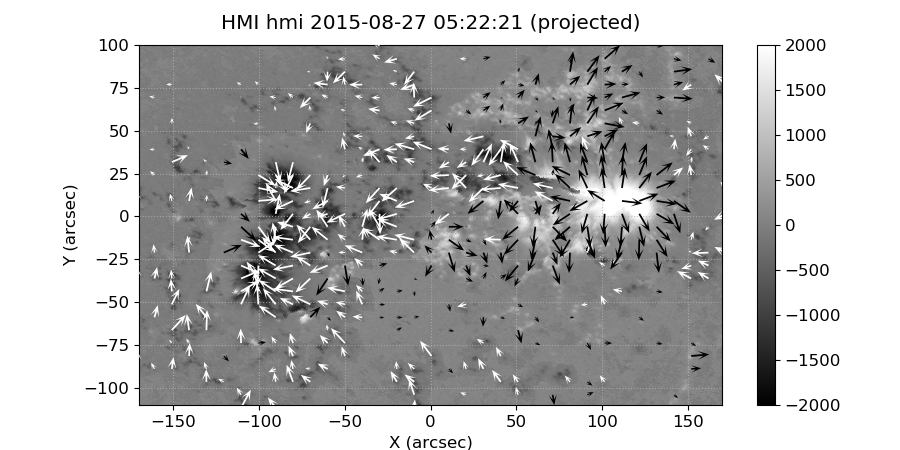

In [8]:
iskip, jskip = (10, 10)

fig3 = plt.figure(figsize=(9, 4.5), dpi=100)
ax3 = fig3.add_subplot(111)
im3 = plot_map(smapbz_h, ax=ax3, coords=(hx, hy), cmap='gray',
               vmin=-2000., vmax=2000., title=mapbz.latex_name+' (projected)')
plot_vmap(smapbx_h, smapby_h, smapbz_h, ax3, coords=(hx, hy),
          iskip=iskip, jskip=jskip, cmin=100., vmax=300., cmap='binary',
          scale_units='xy', scale=1/0.04, minlength=0.02);

# Properties
ax3.grid(True, ls=':', alpha=0.8)
ax3.set_xlim((-170,170))  # arcsec
ax3.set_ylim((-110,100));  # arcsec